# Workshop 1: Introduction to `PyPSA` & TYNDP reference grids

<img src="https://github.com/fneum/data-science-for-esm/raw/main/data-science-for-esm/pypsa-logo.png" width="300px" />

PyPSA stands for **Python for Power System Analysis**.

PyPSA is an open source Python package for simulating and optimising modern energy systems that include features such as

- conventional generators with unit commitment (ramp-up, ramp-down, start-up, shut-down),
- time-varying wind and solar generation,
- energy storage with efficiency losses and inflow/spillage for hydroelectricity
- coupling to other energy sectors (electricity, transport, heat, industry),
- conversion between energy carriers (e.g. electricity to hydrogen),
- transmission networks (AC, DC, other fuels)

PyPSA can be used for a variety of problem types (e.g. electricity market modelling, long-term investment planning, transmission network expansion planning), and is designed to scale well with large networks and long time series.

Compared to building power system by hand in `linopy`, PyPSA does the following things for you:

- manage data inputs
- build optimisation problem
- communicate with the solver
- retrieve and process optimisation results
- manage data outputs

### Dependencies

- `pandas` for storing data about network components and time series
- `numpy` and `scipy` for linear algebra and sparse matrix calculations
- `matplotlib` and `cartopy` for plotting on a map
- `networkx` for network calculations
- `linopy` for handling optimisation problems

:::{note}
Documentation for this package is available at https://pypsa.readthedocs.io.
:::

## Basic Structure

| Component | Description |
| --- | --- |
| [Network](https://pypsa.readthedocs.io/en/latest/components.html#network) | Container for all components. |
| [Bus](https://pypsa.readthedocs.io/en/latest/components.html#bus) | Node where components attach. |
| [Carrier](https://pypsa.readthedocs.io/en/latest/components.html#carrier) | Energy carrier or technology (e.g. electricity, hydrogen, gas, coal, oil, biomass, on-/offshore wind, solar). Can track properties such as specific carbon dioxide emissions or nice names and colors for plots. |
| [Load](https://pypsa.readthedocs.io/en/latest/components.html#load) | Energy consumer (e.g. electricity demand). |
| [Generator](https://pypsa.readthedocs.io/en/latest/components.html#generator) | Generator (e.g. power plant, wind turbine, PV panel). |
| [Link](https://pypsa.readthedocs.io/en/latest/components.html#link) | Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>HVDC links</li><li>HVAC lines (neglecting KVL, only net transfer capacities (NTCs))</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul> |
| [GlobalConstraint](https://pypsa.readthedocs.io/en/latest/components.html#global-constraints) | Constraints affecting many components at once, such as emission limits. |
| **Not covered in this workshop** |  |
| [Line](https://pypsa.readthedocs.io/en/latest/components.html#line) | Power distribution and transmission lines (overhead and cables). |
| [LineType](https://pypsa.readthedocs.io/en/latest/components.html#line-types) | Standard line types. |
| [Transformer](https://pypsa.readthedocs.io/en/latest/components.html#transformer) | 2-winding transformer. |
| [TransformerType](https://pypsa.readthedocs.io/en/latest/components.html#transformer-types) | Standard types of 2-winding transformer. |
| [ShuntImpedance](https://pypsa.readthedocs.io/en/latest/components.html#shunt-impedance) | Shunt. |
| [StorageUnit](https://pypsa.readthedocs.io/en/latest/components.html#storage-unit) | Storage with fixed nominal energy-to-power ratio. |
| [Store](https://pypsa.readthedocs.io/en/latest/components.html#store) | Storage with separately extendable energy capacity. |


:::{note}
Links in the table lead to documentation for each component.
:::

<img src="https://pypsa.readthedocs.io/en/latest/_images/buses.png" width="500px" />


:::{warning}
Per unit values of voltage and impedance are used internally for network calculations. It is assumed internally that the base power is **1 MW**.
:::

## From structured data to optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components.

For an *hourly* electricity market simulation, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{i,s,t}; f_{\ell,t}; g_{i,r,t,\text{charge}}; g_{i,r,t,\text{discharge}}; e_{i,r,t}} \sum_s o_{s} g_{i,s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{i,s,t} \leq \hat{g}_{i,s,t} G_{i,s}  & \text{generation limits : generator} \\
-F_\ell &\leq f_{\ell,t} \leq F_\ell & \text{transmission limits : line}  \\
d_{i,t} &= \sum_s g_{i,s,t} + \sum_r g_{i,r,t,\text{discharge}} - \sum_r g_{i,r,t,\text{charge}} - \sum_\ell K_{i\ell} f_{\ell,t} & \text{KCL : bus} \\
 0 &=\sum_\ell C_{\ell c} x_\ell f_{\ell,t} & \text{KVL : cycles} \\
0 & \leq g_{i,r,t,\text{discharge}} \leq G_{i,r,\text{discharge}}& \text{discharge limits : storage unit} \\
    0 & \leq g_{i,r,t,\text{charge}} \leq G_{i,r,\text{charge}} & \text{charge limits : storage unit} \\
    0 & \leq e_{i,r,t} \leq E_{i,r} & \text{energy limits : storage unit} \\
    e_{i,r,t} &= \eta^0_{i,r,t} e_{i,r,t-1} + \eta^1_{i,r,t}g_{i,r,t,\text{charge}} -  \frac{1}{\eta^2_{i,r,t}} g_{i,r,t,\text{discharge}} & \text{consistency : storage unit} \\
    e_{i,r,0} & = e_{i,r,|T|-1}  & \text{cyclicity : storage unit}
\end{align}

**Decision variables:**

- $g_{i,s,t}$ is the generator dispatch at bus $i$, technology $s$, time step $t$,
- $f_{\ell,t}$ is the power flow in line $\ell$,
- $g_{i,r,t,\text{dis-/charge}}$ denotes the charge and discharge of storage unit $r$ at bus $i$ and time step $t$,
- $e_{i,r,t}$ is the state of charge of storage $r$ at bus $i$ and time step $t$.

**Parameters:**

- $o_{i,s}$ is the marginal generation cost of technology $s$ at bus $i$,
- $x_\ell$ is the reactance of transmission line $\ell$,
- $K_{i\ell}$ is the incidence matrix,
- $C_{\ell c}$ is the cycle matrix,
- $G_{i,s}$ is the nominal capacity of the generator of technology $s$ at bus $i$,
- $F_{\ell}$ is the rating of the transmission line $\ell$,
- $E_{i,r}$ is the energy capacity of storage $r$ at bus $i$,
- $\eta^{0/1/2}_{i,r,t}$ denote the standing (0), charging (1), and discharging (2) efficiencies.

:::{note}
For a full reference to the optimisation problem description, see https://pypsa.readthedocs.io/en/latest/optimal_power_flow.html
:::

# Introduction to pypsa: a minimal dispatch problem

<font size="2">*Copyright (c) 2025, Iegor Riepin*</font>

:::{note}
If you have not yet set up Python on your computer, you can execute this tutorial in your browser via [Google Colab](https://colab.research.google.com/). Click on the rocket in the top right corner and launch "Colab". If that doesn't work download the `.ipynb` file and import it in [Google Colab](https://colab.research.google.com/).

Then install the following packages by executing the following command in a Jupyter cell at the top of the notebook.

```sh
!pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify
```
:::

In [77]:
# To run this notebook in Google Colab, uncomment the following line:
# !pip install pypsa atlite pandas geopandas xarray matplotlib hvplot geoviews plotly highspy holoviews folium mapclassify

In [1]:
# By convention, PyPSA is imported without an alias:
import pypsa

# Other dependencies
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import holoviews as hv
import hvplot.pandas
import cartopy.crs as ccrs
import folium
import mapclassify
from pypsa.plot.maps.static import (
    add_legend_circles,
    add_legend_patches,
    add_legend_lines,
)
from pathlib import Path

plt.style.use("bmh")

### Minimal electricity market problem

generator 1: "gas" -- marginal cost 70 EUR/MWh -- capacity 50 MW

generator 2: "nuclear" -- marginal cost 10 EUR/MWh -- capacity 100 MW

load: "Consumer" -- demand 120 MW

single time step ("now")

single node ("Springfield")

### Building a basic network

In [3]:
# First, we create a network object which serves as the container for all components
n = pypsa.Network(name="Demo")

In [4]:
n

Empty PyPSA Network 'Demo'
--------------------
Components: none
Snapshots: 1

The second component we need are buses. **Buses** are the fundamental nodes of the network, to which all other components like loads, generators and transmission lines attach. They enforce energy conservation for all elements feeding in and out of it (i.e. Kirchhoff’s Current Law).

Components can be added to the network `n` using the `n.add()` function. It takes the component name as a first argument, the name of the component as a second argument and possibly further parameters as keyword arguments. Let's use this function, to add buses for each country to our network:

In [5]:
n.add("Carrier", "AC")
n.add("Bus", "Springfield", v_nom=380, carrier="AC")

Index(['Springfield'], dtype='object')

For each class of components, the data describing the components is stored in a `pandas.DataFrame`. For example, all static data for buses is stored in `n.buses`

In [6]:
n.buses

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network
Bus,,,,,,,,,,,,,
Springfield,380.0,,0.0,0.0,AC,,,1.0,0.0,inf,PQ,,


You see there are many more attributes than we specified while adding the buses; many of them are filled with default parameters which were added. You can look up the field description, defaults and status (required input, optional input, output) for buses here https://pypsa.readthedocs.io/en/latest/components.html#bus, and analogous for all other components.

You can also explore attributes yourself.

In [7]:
n.component_attrs["Bus"]
# n.component_attrs["Generator"]
# n.component_attrs["Link"]
# n.component_attrs["Load"]

,type,unit,default,description,status,static,varying,typ,dtype
attribute,,,,,,,,,
name,string,NaN,,Unique name,Input (required),True,False,<class 'str'>,object
v_nom,float,kV,1.0,Nominal voltage,Input (optional),True,False,<class 'float'>,float64
type,string,NaN,,Placeholder for bus type. Not yet implemented.,Input (optional),True,False,<class 'str'>,object
x,float,NaN,0.0,Position (e.g. longitude); the Spatial Referen...,Input (optional),True,False,<class 'float'>,float64
y,float,NaN,0.0,Position (e.g. latitude); the Spatial Referenc...,Input (optional),True,False,<class 'float'>,float64
carrier,string,NaN,AC,"Energy carrier: can be ""AC"" or ""DC"" for electr...",Input (optional),True,False,<class 'str'>,object
unit,string,NaN,,Unit of the bus’ carrier if the implicitly ass...,Input (optional),True,False,<class 'str'>,object
location,string,NaN,,Location of the bus. Does not influence the op...,Input (optional),True,False,<class 'str'>,object
v_mag_pu_set,static or series,per unit,1.0,"Voltage magnitude set point, per unit of v_nom.",Input (optional),True,True,<class 'float'>,float64


The `n.add()` function lets you add any component to the network object `n`:

In [8]:
n.add(
    "Generator",
    "gas",
    carrier="AC",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=70,  # €/MWh
    p_nom=50,  # MW
)
n.add(
    "Generator",
    "nuclear",
    carrier="AC",
    bus="Springfield",
    p_nom_extendable=False,
    marginal_cost=10,  # €/MWh
    p_nom=100,  # MW
)

Index(['nuclear'], dtype='object')

The method `n.add()` also allows you to add multiple components at once. For instance, multiple **carriers** for the fuels with information on specific carbon dioxide emissions, a nice name, and colors for plotting. For this, the function takes the component name as the first argument and then a list of component names and then optional arguments for the parameters. Here, scalar values, lists, dictionary or `pandas.Series` are allowed. The latter two needs keys or indices with the component names.

As a result, the `n.generators` DataFrame looks like this:

In [9]:
n.generators

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,
gas,Springfield,PQ,,50.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0
nuclear,Springfield,PQ,,100.0,0.0,False,0.0,inf,0.0,1.0,...,0,0,1,0,NaN,NaN,1.0,1.0,1.0,0.0


Next, we're going to add the electricity demand.

A positive value for `p_set` means consumption of power from the bus.

In [10]:
n.add(
    "Load",
    "Small town",
    carrier="AC",
    bus="Springfield",
    p_set=120,  # MW
)

Index(['Small town'], dtype='object')

In [11]:
n.loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
Small town,Springfield,AC,,120.0,0.0,-1.0,True


## Optimisation

The design principle of PyPSA is that basically each component is associated with a set of variables and constraints that will be added to the optimisation model based on the input data stored for the components. 

For this dispatch problem, PyPSA will solve an optimisation problem that looks like this

\begin{equation}
\min_{g_{s,t};} \sum_{t,s} o_{s} g_{s,t}
\end{equation}
such that
\begin{align}
0 & \leq g_{s,t} \leq G_{s}  & \text{generation limits : generator} \\
D_t &= \sum_s g_{s,t} & \text{market clearing : bus} \\
\end{align}

**Decision variables:**

- $g_{s,t}$ is the generator dispatch of technology $s$ at time $t$

**Parameters:**

- $o_{s}$ is the marginal generation cost of technology $s$
- $G_{s}$ is the nominal capacity of technology $s$
- $D_t$ is the power demand in Springfiled at time $t$


With all input data transferred into the PyPSA's data structure (`network`), we can now build and run the resulting optimisation problem. In PyPSA, building, solving and retrieving results from the optimisation model is contained in a single function call `n.optimize()`. This function optimizes dispatch and investment decisions for least cost adhering to the constraints defined in the network.

The `n.optimize()` function can take a variety of arguments. The most relevant for the moment is the choice of the solver (e.g. "highs" and "gurobi"). They need to be installed on your computer, to use them here!

In [12]:
n.optimize(solver_name="highs")

INFO:linopy.model: Solve problem using Highs solver
INFO:linopy.io: Writing time: 0.01s
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 2 primals, 5 duals
Objective: 2.40e+03
Solver model: available
Solver message: optimal

INFO:pypsa.optimization.optimize:The shadow-prices of the constraints Generator-fix-p-lower, Generator-fix-p-upper were not assigned to the network.


Running HiGHS 1.10.0 (git hash: fd86653): Copyright (c) 2025 HiGHS under MIT licence terms
LP   linopy-problem-_84o1eau has 5 rows; 2 cols; 6 nonzeros
Coefficient ranges:
  Matrix [1e+00, 1e+00]
  Cost   [1e+01, 7e+01]
  Bound  [0e+00, 0e+00]
  RHS    [5e+01, 1e+02]
Presolving model
0 rows, 0 cols, 0 nonzeros  0s
0 rows, 0 cols, 0 nonzeros  0s
Presolve : Reductions: rows 0(-5); columns 0(-2); elements 0(-6) - Reduced to empty
Solving the original LP from the solution after postsolve
Model name          : linopy-problem-_84o1eau
Model status        : Optimal
Objective value     :  2.4000000000e+03
Relative P-D gap    :  0.0000000000e+00
HiGHS run time      :          0.00
Writing the solution to /private/var/folders/mc/ydz19ftd49sd7q8qgcq53tkh0000gn/T/linopy-solve-suofappb.sol


('ok', 'optimal')

Let's have a look at the results. The network object `n` contains now the objective value and the results for the decision variables.

In [13]:
n.objective

2400.0

Since the power flow and dispatch are generally time-varying quantities, these are stored in a different locations than e.g. `n.generators`. They are stored in `n.generators_t`. Thus, to find out the dispatch of the generators, run

In [14]:
n.generators_t.p

Generator,gas,nuclear
snapshot,,
now,20.0,100.0


In [15]:
n.buses_t.marginal_price

Bus,Springfield
snapshot,
now,70.0


## Explore pypsa model

In [16]:
n.model

Linopy LP model

Variables:
----------
 * Generator-p (snapshot, Generator)

Constraints:
------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Bus-nodal_balance (Bus, snapshot)

Status:
-------
ok

In [17]:
n.model.constraints

linopy.model.Constraints
------------------------
 * Generator-fix-p-lower (snapshot, Generator-fix)
 * Generator-fix-p-upper (snapshot, Generator-fix)
 * Bus-nodal_balance (Bus, snapshot)

In [18]:
n.model.constraints["Generator-fix-p-upper"]

Constraint `Generator-fix-p-upper` [snapshot: 1, Generator-fix: 2]:
-------------------------------------------------------------------
[now, gas]: +1 Generator-p[now, gas]         ≤ 50.0
[now, nuclear]: +1 Generator-p[now, nuclear] ≤ 100.0

In [19]:
n.model.constraints["Bus-nodal_balance"]

Constraint `Bus-nodal_balance` [Bus: 1, snapshot: 1]:
-----------------------------------------------------
[Springfield, now]: +1 Generator-p[now, gas] + 1 Generator-p[now, nuclear] = 120.0

In [20]:
n.model.objective

Objective:
----------
LinearExpression: +70 Generator-p[now, gas] + 10 Generator-p[now, nuclear]
Sense: min
Value: 2400.0

# Building the reference grids

The minimal `PyPSA` example illustrates how time-consuming it can be to compose a network by hand. To simplify the work, `PyPSA-Eur` provides a set of scripts that does this for you. It collects and processes open data, composes a network, writes the constraints, solves the operation and capacity expansion problem, collects the result and produces basic summary outputs for analysis.

The current `open-tyndp` project aims to adapt `PyPSA-Eur` to the specific needs of the TYNDP process. All the code is openly available in the project repository: [open-tyndp](https://github.com/open-energy-transition/open-tyndp). Currently, the workflow implements the reference grid data for both the electricity and hydrogen networks and solves the network with the default `PyPSA-Eur` demand.

As any open-source repository, you can get the code, contribute using pull-requests, reports issues and submit feature requests.

## Load example data

For this workshop, we have prepared networks that can be explored immediately:
- `pre-network`: The network prepared by the workflow before solving it.
- `post-network`: The solved network.

As this workshop focuses on the reference grid, we will also explore the bidding zones data we have created.

In [21]:
from urllib.request import urlretrieve

urls = {
    "pre-network.nc": "https://drive.google.com/uc?export=download&id=1KizODRyW0UVLKzIY5MZlDZi52zN0tSZc",
    "post-network.nc": "https://drive.google.com/uc?export=download&id=1O9bkv7382rAhnY493aa9SLaXl4AdVfSw",
    "bidding_zones.geojson": "https://drive.google.com/uc?export=download&id=1ZjcNdSiE9OTUetcV1MBV8qn6KIKMYQkM",
}
for name, url in urls.items():
    print(f"Retrieve {name} from Google Drive")
    urlretrieve(url, name)
print("Done")

Retrieve pre-network.nc from Google Drive
Retrieve post-network.nc from Google Drive
Retrieve bidding_zones.geojson from Google Drive
Done


First, let's load a pre-composed PyPSA Network:

In [22]:
n = pypsa.Network("pre-network.nc")

INFO:pypsa.io:Imported network pre-network.nc has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


And let's get a general overview of the components in it:

In [23]:
n

PyPSA Network 'PyPSA-Eur (tyndp-raw)'
-------------------------------------
Components:
 - Bus: 670
 - Carrier: 76
 - Generator: 656
 - GlobalConstraint: 2
 - Link: 2059
 - Load: 197
 - Shape: 62
 - StorageUnit: 69
 - Store: 349
Snapshots: 365

We have buses which represent the different nodes in the model where components attach.

In [24]:
n.buses.head()

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_off,substation_lv
Bus,,,,,,,,,,,,,,,,
AL00,380.0,,20.036884,41.117588,AC,MWh_el,AL00,1.0,0.0,inf,PQ,,,AL,1.0,1.0
AT00,380.0,,14.822183,47.668898,AC,MWh_el,AT00,1.0,0.0,inf,PQ,,,AT,1.0,1.0
BA00,380.0,,17.867837,43.982016,AC,MWh_el,BA00,1.0,0.0,inf,PQ,,,BA,1.0,1.0
BE00,380.0,,4.967931,50.470635,AC,MWh_el,BE00,1.0,0.0,inf,PQ,,,BE,1.0,1.0
BG00,380.0,,25.323948,42.668760,AC,MWh_el,BG00,1.0,0.0,inf,PQ,,,BG,1.0,1.0


And let's look at electric buses for a specific country.

In [25]:
n.buses.query("country=='IT' and carrier=='AC'")

,v_nom,type,x,y,carrier,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_off,substation_lv
Bus,,,,,,,,,,,,,,,,
ITCA,380.0,,16.634892,38.985885,AC,MWh_el,ITCA,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITCN,380.0,,11.238605,43.418039,AC,MWh_el,ITCN,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITCS,380.0,,13.162117,41.846461,AC,MWh_el,ITCS,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITN1,380.0,,9.703872,45.440276,AC,MWh_el,ITN1,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITS1,380.0,,16.501565,40.927422,AC,MWh_el,ITS1,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITSA,380.0,,9.097371,40.067626,AC,MWh_el,ITSA,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITSI,380.0,,13.863833,37.546811,AC,MWh_el,ITSI,1.0,0.0,inf,PQ,,,IT,1.0,1.0
ITVI,380.0,,13.863833,37.546811,AC,MWh_el,ITVI,1.0,0.0,inf,PQ,,,IT,0.0,0.0
IT H2 Z2 DRES,380.0,,16.634892,38.985885,AC,MWh_el,IT H2 Z2,1.0,0.0,inf,PQ,,,IT,1.0,1.0


Generators which represent generating units (e.g. wind turbine, PV panel):

In [26]:
n.generators.head()

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,location,unit
Generator,,,,,,,,,,,,,,,,,,,,,
AL00 solar,AL00,PQ,,21.000,0.0,True,21.000,54290.334494,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
AT00 solar,AT00,PQ,,2042.934,0.0,True,2042.934,176044.784305,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
BA00 solar,BA00,PQ,,34.890,0.0,True,34.890,87211.070267,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
BE00 solar,BE00,PQ,,5572.800,0.0,True,5572.800,106452.313693,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,
BG00 solar,BG00,PQ,,1100.211,0.0,True,1100.211,232654.182098,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,0.0,,


Links connect two buses with controllable energy flow, direction-control and losses. They can be used to model: <ul><li>**HVAC lines (neglecting KVL, only net transfer capacities (NTCs))**</li><li>HVDC links</li><li>conversion between carriers (e.g. electricity to hydrogen in electrolysis)</li></ul>

PyPSA-Eur uses `DC` as the conventional carrier for electrical transmission lines modelled as `Link`. `AC` is used as the conventional carrier for electrical transmission `Line`.

In [27]:
n.links.head()

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,voltage,energy to power ratio,bidirectional,dc,under_construction,underground,tags,underwater_fraction,geometry,reversed
Link,,,,,,,,,,,,,,,,,,,,,
AL00-GR00-DC,AL00,GR00,,DC,1.0,True,0,inf,600.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> GR00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AL00-ME00-DC,AL00,ME00,,DC,1.0,True,0,inf,400.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> ME00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AL00-MK00-DC,AL00,MK00,,DC,1.0,True,0,inf,500.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> MK00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AL00-RS00-DC,AL00,RS00,,DC,1.0,True,0,inf,250.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> RS00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AT00-CH00-DC,AT00,CH00,,DC,1.0,True,0,inf,1200.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AT00 -> CH00,0.0,LINESTRING (14.822183225330722 47.668898155000...,False


You can filter a country.

In [28]:
n.links.query("Link.str.contains('DE')").head()

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,voltage,energy to power ratio,bidirectional,dc,under_construction,underground,tags,underwater_fraction,geometry,reversed
Link,,,,,,,,,,,,,,,,,,,,,
AT00-DE00-DC,AT00,DE00,,DC,1.0,True,0,inf,7500.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AT00 -> DE00,0.0,LINESTRING (14.822183225330722 47.668898155000...,False
BE00-DE00-DC,BE00,DE00,,DC,1.0,True,0,inf,1000.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,BE00 -> DE00,0.0,LINESTRING (4.96793113501169 50.47063494467691...,False
CH00-DE00-DC,CH00,DE00,,DC,1.0,True,0,inf,4200.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,CH00 -> DE00,0.0,LINESTRING (8.343016848147014 46.7336228266206...,False
CZ00-DE00-DC,CZ00,DE00,,DC,1.0,True,0,inf,2600.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,CZ00 -> DE00,0.0,LINESTRING (15.66368315845627 49.7526624846696...,False
DE00-AT00-DC,DE00,AT00,,DC,1.0,True,0,inf,7500.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,DE00 -> AT00,0.0,LINESTRING (10.11340015140031 51.1099148631177...,False


The workflow also attaches `Load` to the network. As the load is a time sensitive information, the data is stored in `n.loads_t`. The provided network uses the default PyPSA-Eur loads.

In [29]:
n.loads_t.p_set.head()

Load,AL00,AL00 rural heat,AL00 urban central heat,AL00 urban decentral heat,AT00,AT00 rural heat,AT00 urban central heat,AT00 urban decentral heat,BA00,BA00 rural heat,...,SE04 urban central heat,SE04 urban decentral heat,SI00,SI00 rural heat,SI00 urban central heat,SI00 urban decentral heat,SK00,SK00 rural heat,SK00 urban central heat,SK00 urban decentral heat
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,94.054701,284.576780,101.601203,402.478194,6212.087884,4965.054740,2773.002601,4512.187078,852.302881,1098.846862,...,4632.595627,3758.233284,939.316832,1005.085529,447.774568,961.898411,1905.210425,2782.897418,1578.239034,2499.366656
2013-01-05 09:00:00,60.212280,324.207634,115.750433,458.528286,6484.498296,4234.916892,2365.217741,3848.645840,882.688622,1100.271371,...,5163.069162,4188.584528,1011.963207,908.140821,404.584836,869.119282,1982.056636,2926.617535,1659.745703,2628.444093
2013-01-07 22:00:00,-31.213006,402.414140,143.672160,569.136092,7038.728789,4670.032568,2608.231557,4244.074176,781.844597,1283.629924,...,4762.392651,3863.532243,1132.739082,1014.491344,451.964942,970.900071,1973.238451,3614.315685,2049.753634,3246.077290
2013-01-09 07:00:00,-19.715825,391.448202,139.757039,553.626917,7548.002926,4767.189660,2662.494175,4332.369471,881.525069,1138.036042,...,5561.270596,4511.628887,1250.518510,958.242310,426.905495,917.067979,2219.742604,3355.508607,1902.978755,3013.638330
2013-01-10 10:00:00,80.224438,303.199075,108.249839,428.815789,7096.774785,5547.752309,3098.441485,5041.736212,872.035233,1130.548251,...,6524.575355,5293.118208,1159.688642,1048.937066,467.310818,1003.865708,2102.271285,3443.165703,1952.690918,3092.364632


PyPSA-Eur makes use of `GlobalConstraints` to limit, for example, the total line expansion and the global carbon emissions.

In [30]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
lv_limit,transmission_volume_expansion_limit,NaN,"AC, DC",<=,1.555173e+08,0.0
CO2Limit,co2_atmosphere,NaN,co2_emissions,<=,6.548277e+08,0.0


## Explore bidding zones

Let's start by examining the bidding zones, as they define the spatial resolution of the electricity grid for the Scenario Building.

Let's load and explore the bidding zone shapes that we created for the model:

In [31]:
bz = gpd.read_file("bidding_zones.geojson")
bz.head()

,zone_name,country,cross_country_zone,geometry
0,AL00,AL,None,"MULTIPOLYGON (((20.56881 41.87367, 20.50041 42..."
1,AT00,AT,None,"MULTIPOLYGON (((16.94357 48.60406, 16.87157 48..."
2,BA00,BA,None,"MULTIPOLYGON (((19.02249 44.85585, 18.84298 44..."
3,BE00,BE,None,"MULTIPOLYGON (((2.52183 51.08698, 2.59023 50.8..."
4,BG00,BG,None,"MULTIPOLYGON (((26.33246 41.71339, 26.54847 41..."


Let's use a nice interactive plotting package to plot the regions.

`.hvplot()` is a powerful and interactive Pandas-like `.plot()` API. You just replace `.plot()` with `.hvplot()` and you get an interactive figure.

Documentation can be found here: https://hvplot.holoviz.org/index.html

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
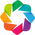

:Overlay
   .WMTS.I     :WMTS   [Longitude,Latitude]
   .Polygons.I :Polygons   [Longitude,Latitude]   (zone_name,country)

In [32]:
hv.extension("bokeh")
bz.hvplot(
    geo=True,
    tiles="OSM",
    hover_cols=["zone_name", "country"],
    c="zone_name",
    frame_height=700,
    frame_width=1000,
    alpha=0.2,
    legend=False,
).opts(xaxis=None, yaxis=None, active_tools=["pan", "wheel_zoom"])

In [33]:
# Task: explore the bidding zones geographies

## Explore the Electricity reference grid

The Electricity reference grid in the `PyPSA` model was implemented as HVAC lines that neglect KVL and only net transfer capacities (NTCs).

This is referred to as a `Transport Model`.

In `PyPSA`, this can be represented by the `link` component with carrier set to 'DC'.

Let's have a look at those links:

In [34]:
reference_grid_elec = n.links.query("carrier == 'DC'")
reference_grid_elec.head()

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,voltage,energy to power ratio,bidirectional,dc,under_construction,underground,tags,underwater_fraction,geometry,reversed
Link,,,,,,,,,,,,,,,,,,,,,
AL00-GR00-DC,AL00,GR00,,DC,1.0,True,0,inf,600.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> GR00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AL00-ME00-DC,AL00,ME00,,DC,1.0,True,0,inf,400.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> ME00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AL00-MK00-DC,AL00,MK00,,DC,1.0,True,0,inf,500.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> MK00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AL00-RS00-DC,AL00,RS00,,DC,1.0,True,0,inf,250.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AL00 -> RS00,0.0,LINESTRING (20.036883988642362 41.117587702511...,False
AT00-CH00-DC,AT00,CH00,,DC,1.0,True,0,inf,1200.0,0.0,...,380.0,NaN,NaN,1.0,0.0,1.0,AT00 -> CH00,0.0,LINESTRING (14.822183225330722 47.668898155000...,False


That's a lot of information! Let's filter out some useful attributes.

In [35]:
reference_grid_elec.loc[:, ["bus0", "bus1", "p_nom", "p_nom_opt", "length"]].head()

,bus0,bus1,p_nom,p_nom_opt,length
Link,,,,,
AL00-GR00-DC,AL00,GR00,600.0,0.0,219.635111
AL00-ME00-DC,AL00,ME00,400.0,0.0,189.342890
AL00-MK00-DC,AL00,MK00,500.0,0.0,153.308707
AL00-RS00-DC,AL00,RS00,250.0,0.0,351.420535
AT00-CH00-DC,AT00,CH00,1200.0,0.0,502.028400


You can observe that the `p_nom_opt` is not defined yet as this model was not solved yet.

You can narrow down to a specific country.

In [36]:
(
    reference_grid_elec.loc[:, ["bus0", "bus1", "p_nom", "p_nom_opt", "length"]].query(
        "Link.str.contains('ES')"
    )
)

,bus0,bus1,p_nom,p_nom_opt,length
Link,,,,,
ES00-FR00-DC,ES00,FR00,5000.0,0.0,818.531610
ES00-PT00-DC,ES00,PT00,4200.0,0.0,469.515817
FR00-ES00-DC,FR00,ES00,5000.0,0.0,818.531610
PT00-ES00-DC,PT00,ES00,3500.0,0.0,469.515817


The model implements NTCs as unidirectional links. Electricity flows from `bus0` (source) to `bus1` (sink).

With the capacitiy `p_nom` and the `length`, we can also compute the total transmission capacity of the system in `TWkm`:

In [37]:
total_TWkm = (
    reference_grid_elec.p_nom.div(1e6)  # convert from PyPSA's base unit MW to TW
    .mul(reference_grid_elec.length)
    .sum()
    .round(2)
)
print(
    f"Total electricity reference grid has a transmission capacity of {total_TWkm} TWkm."
)

Total electricity reference grid has a transmission capacity of 155.52 TWkm.


We can also check some individual number for specific connections using the `.query()` or the `.filter(like='<your-filter>')` method. `.filter` has the limitation to only work on indexes and column names.

In [38]:
# example
# `query()`
print(reference_grid_elec.query("Link.str.contains('DE00-BE00')").p_nom)  # in MW
# or `filter()`
print(reference_grid_elec.filter(like="DE00-BE00", axis=0).p_nom)

Link
DE00-BE00-DC    1000.0
Name: p_nom, dtype: float64
Link
DE00-BE00-DC    1000.0
Name: p_nom, dtype: float64


In [39]:
# Task: extract and filter for specific capacity information from your home country
# and compare with your data about these connections

In [40]:
# Task: create a table with the import transmission capacity for each country.
# Task: which country has the largest total?
# Hint: use pandas `groupby` method

Additionally, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the electricity reference grid:

In [41]:
# create a copy of the network which only includes electricity
n_elec_grid = n.copy()
n_elec_grid.remove(
    "Bus", n_elec_grid.buses.query("carrier != 'AC' or Bus.str.contains('DRES')").index
)

# explore the reference grid
n_elec_grid.plot.explore()

INFO:pypsa.plot.maps.interactive:Omitting 1842 links due to missing coordinates.
INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Link.
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer.


We can also statically plot the electricity grid by utilizing a handy plotting function:

In [42]:
def plot_electricity_reference_grid(n, proj, lw_factor=1e3, figsize=(12, 12)):
    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})
    n.plot.map(
        ax=ax,
        margin=0.06,
        link_widths=n.links.p_nom / lw_factor,
        link_colors="darkseagreen",
    )

    if not n.links.empty:
        sizes_ntc = [1, 5]
        labels_ntc = [f"NTC ({s} GW)" for s in sizes_ntc]
        scale_ntc = 1e3 / lw_factor
        sizes_ntc = [s * scale_ntc for s in sizes_ntc]

        legend_kw_dc = dict(
            loc=[0.0, 0.9],
            frameon=False,
            labelspacing=0.5,
            handletextpad=1,
            fontsize=13,
        )

        add_legend_lines(
            ax,
            sizes_ntc,
            labels_ntc,
            patch_kw=dict(color="darkseagreen"),
            legend_kw=legend_kw_dc,
        )

    plt.show()


def load_projection(plotting_params):
    proj_kwargs = plotting_params.get("projection", dict(name="EqualEarth"))
    proj_func = getattr(ccrs, proj_kwargs.pop("name"))
    return proj_func(**proj_kwargs)


proj = load_projection(dict(name="EqualEarth"))

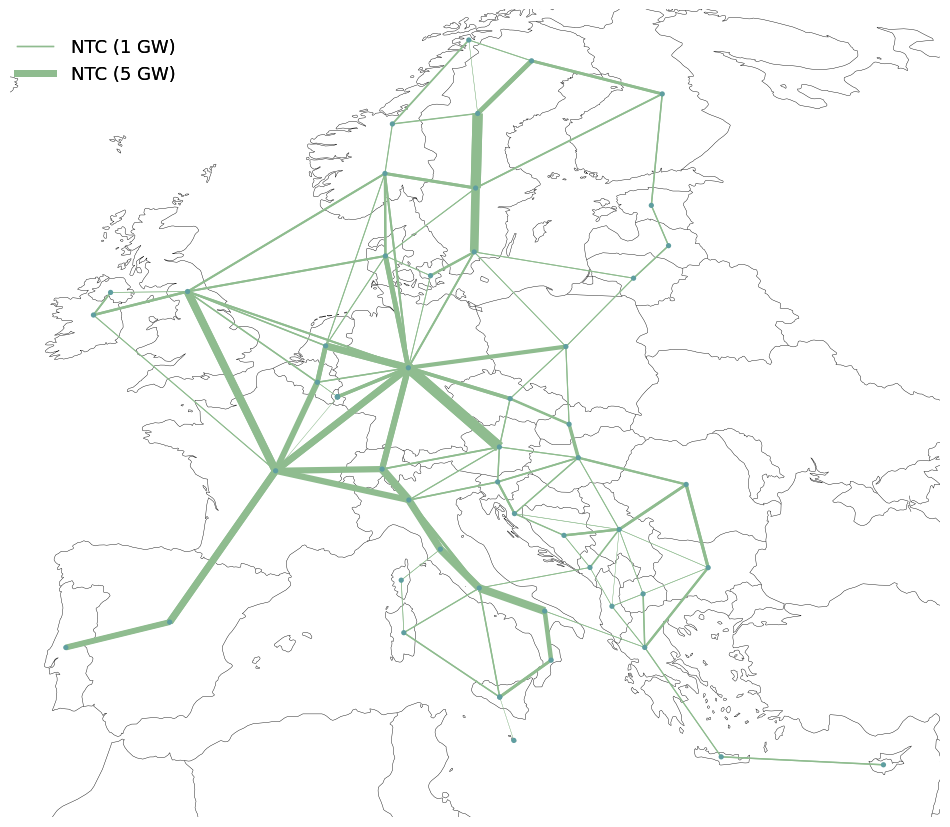

In [43]:
plot_electricity_reference_grid(n_elec_grid, proj)

You've just created the reference grid published in the [Scenarios Methodology report from TYNDP 2024](https://2024.entsos-tyndp-scenarios.eu/download/)!

## Explore the Hydrogen reference grid

Similar to the Electricity reference grid, the H2 reference grid in the `PyPSA` model was implemented using the `link` component to represent the transport model of the Scenario Building.

Let's have a look at those Hydrogen reference grid links:

In [44]:
reference_grid_h2 = n.links.query("carrier == 'H2 pipeline'")
reference_grid_h2.head()

,bus0,bus1,type,carrier,efficiency,active,build_year,lifetime,p_nom,p_nom_mod,...,voltage,energy to power ratio,bidirectional,dc,under_construction,underground,tags,underwater_fraction,geometry,reversed
Link,,,,,,,,,,,,,,,,,,,,,
H2 pipeline AT -> DE,AT H2 Z2,DE H2 Z2,,H2 pipeline,1.0,True,0,50.0,6250.0,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,,NaN,,False
H2 pipeline AT -> IBIT,AT H2 Z2,IBIT H2 Z2,,H2 pipeline,1.0,True,0,50.0,5250.0,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,,NaN,,False
H2 pipeline AT -> SI,AT H2 Z2,SI H2 Z2,,H2 pipeline,1.0,True,0,50.0,0.0,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,,NaN,,False
H2 pipeline AT -> SK,AT H2 Z2,SK H2 Z2,,H2 pipeline,1.0,True,0,50.0,6000.0,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,,NaN,,False
H2 pipeline BE -> DE,BE H2 Z2,DE H2 Z2,,H2 pipeline,1.0,True,0,50.0,3790.0,0.0,...,NaN,NaN,0.0,NaN,NaN,NaN,,NaN,,False


Again, it's a lot of information! Let's filter out some useful attributes.

In [45]:
reference_grid_h2.loc[:, ["bus0", "bus1", "p_nom", "p_nom_opt", "length"]].head()

,bus0,bus1,p_nom,p_nom_opt,length
Link,,,,,
H2 pipeline AT -> DE,AT H2 Z2,DE H2 Z2,6250.0,0.0,768.287118
H2 pipeline AT -> IBIT,AT H2 Z2,IBIT H2 Z2,5250.0,0.0,694.620395
H2 pipeline AT -> SI,AT H2 Z2,SI H2 Z2,0.0,0.0,247.449222
H2 pipeline AT -> SK,AT H2 Z2,SK H2 Z2,6000.0,0.0,469.275999
H2 pipeline BE -> DE,BE H2 Z2,DE H2 Z2,3790.0,0.0,552.792303


Now, focusing on interconnections between two specific countries.

In [46]:
# Task: choose two countries and find the right H2 pipelines connecting the two
# Hint: use pandas `query` method

Again, we can compute the total transmission capacity of the system in `TWkm`:

In [47]:
# Task: without looking at the previous section, can you remember how to calculate this

Again, we can also use `PyPSA`'s built in interactive `n.plot.explore()` function to explore the hydrogen reference grid. 

As we can see, the spatial resolution of the H2 reference grid is different to the electricity reference grid.

In [48]:
# create a copy of the network which only includes electricity
n_h2_grid = n.copy()
n_h2_grid.remove("Bus", n_h2_grid.buses.query("carrier != 'H2'").index)
n_h2_grid.remove("Link", n_h2_grid.links.query("p_nom == 0").index)

# explore the reference grid
n_h2_grid.plot.explore()

INFO:pypsa.plot.maps.interactive:Omitting 208 links due to missing coordinates.
INFO:pypsa.plot.maps.interactive:Components rendered on the map: Bus, Link.
INFO:pypsa.plot.maps.interactive:Components omitted as they are missing or not selected: Generator, Line, Load, StorageUnit, Transformer.


We can also plot the hydrogen grid by utilizing another handy plotting function:

In [49]:
def plot_h2_reference_grid(
    n,
    proj,
    lw_factor=4e3,
    figsize=(12, 12),
    color_h2_pipe="#499a9c",
    color_h2_node="#ff29d9",
):
    n = n.copy()

    n.links.drop(
        n.links.index[~n.links.carrier.str.contains("H2 pipeline")], inplace=True
    )
    h2_pipes = n.links[n.links.carrier == "H2 pipeline"].p_nom

    link_widths_total = h2_pipes / lw_factor
    if link_widths_total.notnull().empty:
        print("No base H2 pipeline capacities to plot.")
        return
    link_widths_total = link_widths_total.reindex(n.links.index).fillna(0.0)

    n.buses.drop(n.buses.index[~n.buses.carrier.str.contains("H2")], inplace=True)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})

    n.plot.map(
        geomap=True,
        bus_sizes=0.1,
        bus_colors=color_h2_node,
        link_colors=color_h2_pipe,
        link_widths=link_widths_total,
        branch_components=["Link"],
        ax=ax,
    )

    sizes = [30, 10]
    labels = [f"{s} GW" for s in sizes]
    scale = 1e3 / 4e3
    sizes = [s * scale for s in sizes]

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.005, 1.1),
        frameon=False,
        ncol=2,
        labelspacing=0.8,
        handletextpad=1,
    )

    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color="lightgrey"),
        legend_kw=legend_kw,
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0.15, 1.13),
        labelspacing=0.8,
        handletextpad=0,
        frameon=False,
    )

    add_legend_circles(
        ax,
        sizes=[0.2],
        labels=["H2 Node"],
        srid=n.srid,
        patch_kw=dict(facecolor=color_h2_node),
        legend_kw=legend_kw,
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(0, 1.13),
        ncol=1,
        frameon=False,
    )

    add_legend_patches(ax, [color_h2_pipe], ["H2 Pipeline"], legend_kw=legend_kw)

    ax.set_facecolor("white")

    plt.show()

/Users/daniel/mambaforge/envs/open-tyndp-workshops/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1678: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend circle sizes.



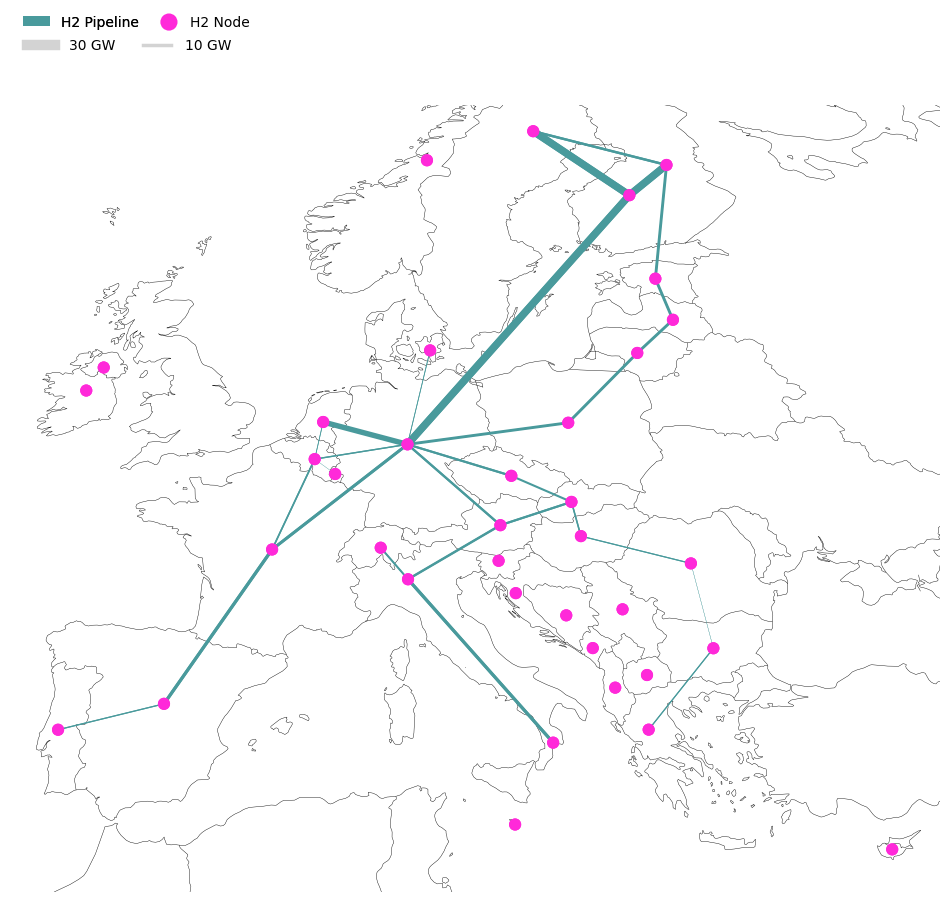

In [50]:
plot_h2_reference_grid(n_h2_grid, proj)

You've just created the hydrogen reference grid published in the [Scenarios Methodology report from TYNDP 2024](https://2024.entsos-tyndp-scenarios.eu/download/)!

# Extracting insights & Visualization

## Import the solved model

In [51]:
n = pypsa.Network("post-network.nc")

INFO:pypsa.io:Imported network post-network.nc has buses, carriers, generators, global_constraints, links, loads, shapes, storage_units, stores


## Extract insights from the network using `PyPSA.statistics`

Let's investigate the results from the solved model. For convenience, let's save the accessor in a variable.

The full API documentation is available in [pypsa documentation](https://pypsa.readthedocs.io/en/latest/api/statistics.html).

In [52]:
s = n.statistics

You can easily have an comprehensive overview of the system level results.

In [53]:
s().head()

Optimal Capacity  Installed Capacity  \
Generator Offshore Wind (AC)             42222.14693          6580.28372   
          Offshore Wind (DC)             50674.90378         13350.65347   
          Offshore Wind (Floating)        5074.36771          5074.35608   
          Onshore Wind                  326788.62626        184845.68700   
          Run of River                   47774.12902         47774.12902   

                                          Supply  Withdrawal  Energy Balance  \
Generator Offshore Wind (AC)        1.765378e+08         0.0    1.765378e+08   
          Offshore Wind (DC)        2.500630e+08         0.0    2.500630e+08   
          Offshore Wind (Floating)  2.122442e+07         0.0    2.122442e+07   
          Onshore Wind              8.147271e+08         0.0    8.147271e+08   
          Run of River              1.698666e+08         0.0    1.698666e+08   

                                    Transmission  Capacity Factor  \
Generator Offshore Wind (AC)                 0.0         0.477302   
          Offshore Wind (DC)                 0.0         0.563316   
          Offshore Wind (Floating)           0.0         0.477474   
          Onshore Wind                       0.0         0.284604   
          Run of River                       0.0         0.405893   

                                     Curtailment  Capital Expenditure  \
Generator Offshore Wind (AC)        1.502211e+06         8.531506e+09   
          Offshore Wind (DC)        1.095987e+06         1.165300e+10   
          Offshore Wind (Floating)  5.647373e+05         1.251261e+09   
          Onshore Wind              1.656320e+07         3.781592e+10   
          Run of River              6.082543e+05         1.472257e+10   

                                    Operational Expenditure       Revenue  \
Generator Offshore Wind (AC)                   4.466614e+06  8.606860e+09   
          Offshore Wind (DC)                   6.209362e+06  1.197855e+10   
          Offshore Wind (Floating)             5.418262e+05  9.005340e+08   
          Onshore Wind                         2.050222e+07  3.295203e+10   
          Run of River                         1.727120e+06  8.341871e+09   

                                    Market Value  
Generator Offshore Wind (AC)           48.753643  
          Offshore Wind (DC)           47.902146  
          Offshore Wind (Floating)     42.429142  
          Onshore Wind                 40.445483  
          Run of River                 49.108367

Let's have a look to optimal renewable capacities.

In [54]:
s.optimal_capacity(
    bus_carrier=["AC", "low voltage"],
    comps="Generator",
).div(
    1e3
)  # GW

carrier
Offshore Wind (AC)           42.222147
Offshore Wind (DC)           50.674904
Offshore Wind (Floating)      5.074368
Onshore Wind                326.788626
Run of River                 47.774129
Solar                       152.958176
solar rooftop               486.472898
solar-hsat                   72.962272
dtype: float64

You can get it as fancy as you want!

In [55]:
(
    s.optimal_capacity(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
        comps="Generator",
    )
    .div(1e3)  # GW
    .to_frame(name="p_nom_opt")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .assign(Total=lambda df: df.sum(axis=1))
    .sort_values(by="Total", ascending=False)
    .round(2)
).head()

carrier,Offshore Wind (AC),Offshore Wind (DC),Offshore Wind (Floating),Onshore Wind,Run of River,Solar,solar rooftop,solar-hsat,Total
location,,,,,,,,,
FR00,27.60,6.91,0.00,17.48,6.51,11.06,121.44,0.00,191.01
ES00,0.00,0.00,0.00,26.81,0.28,10.14,84.74,45.05,167.03
DE00,4.24,21.70,0.53,54.41,4.76,53.67,6.06,0.00,145.37
GB00,3.27,3.28,3.57,79.10,2.87,12.52,0.00,0.00,104.62
ITN1,0.00,0.00,0.00,1.45,5.26,5.91,41.89,0.00,54.51


In [56]:
# Task: try to fine tune this query to your needs

We can also easily look into the energy balance for a specific carrier by Node. 

So, let's investigate the Hydrogen balance at the Z1 and Z2 nodes of Germany (DE):

In [57]:
(
    s.energy_balance(
        carrier="H2",
        groupby=["bus", "country", "carrier"],
    )
    .div(1e6)  # TWh
    .to_frame(name="Balance [TWh]")
    .query("bus.str.contains('DE H2')")
    .round(2)
)

Balance [TWh]
component bus      country carrier                       
Link      DE H2 Z1 DE      H2 Electrolysis            0.0
                           H2 pipeline               -0.0
          DE H2 Z2 DE      H2 Electrolysis            0.0
                           H2 pipeline                0.0
                           H2 turbine                -0.0

... or look at renewable curtailment in the system:

In [58]:
(
    s.curtailment(
        bus_carrier=["AC", "low voltage"],
        groupby=["location", "carrier"],
    )
    .div(1e6)  # TWh
    .to_frame(name="p_nom_opt")
    .pivot_table(index="location", columns="carrier", values="p_nom_opt")
    .fillna(0)
    .assign(Total=lambda df: df.sum(axis=1))
    .sort_values(by="Total", ascending=False)
    .round(2)
).head()

carrier,Offshore Wind (AC),Offshore Wind (DC),Offshore Wind (Floating),Onshore Wind,Pumped Hydro Storage,Reservoir & Dam,Run of River,Solar,solar rooftop,solar-hsat,Total
location,,,,,,,,,,,
ES00,0.00,0.00,0.0,2.66,83.14,98.52,0.0,0.06,9.32,14.92,208.63
CH00,0.00,0.00,0.0,0.00,47.19,68.73,0.0,0.00,0.07,0.00,115.99
NOS0,0.00,0.00,0.0,0.00,1.58,113.26,0.0,0.00,0.00,0.00,114.84
FR00,1.19,0.19,0.0,0.25,38.56,27.26,0.0,0.04,2.44,0.00,69.94
AT00,0.00,0.00,0.0,0.00,49.14,20.30,0.0,0.00,0.01,0.00,69.46


In [59]:
# Task: explore the documentation and try this out yourself

## Visualizing results using `PyPSA.statistics`

The `PyPSA.statistics` module can also be used to create some really handy static plotting to investigate the results of a model.

In [60]:
# let's fill missing colors first
n.carriers.loc["none", "color"] = "#000000"
n.carriers.loc["", "color"] = "#000000"

Let's now plot the optimal renewable capacities that we investigated before.

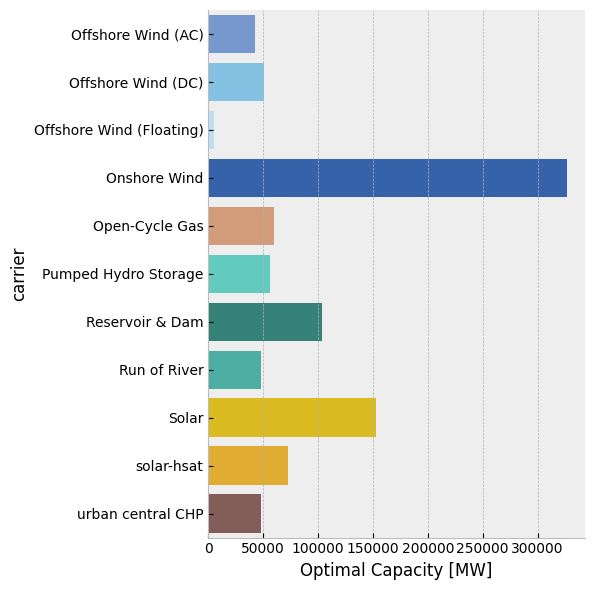

In [61]:
s.optimal_capacity.plot.bar(
    bus_carrier="AC",
    query="value>1e3",
    height=6,
);

You can also have details for specific countries.

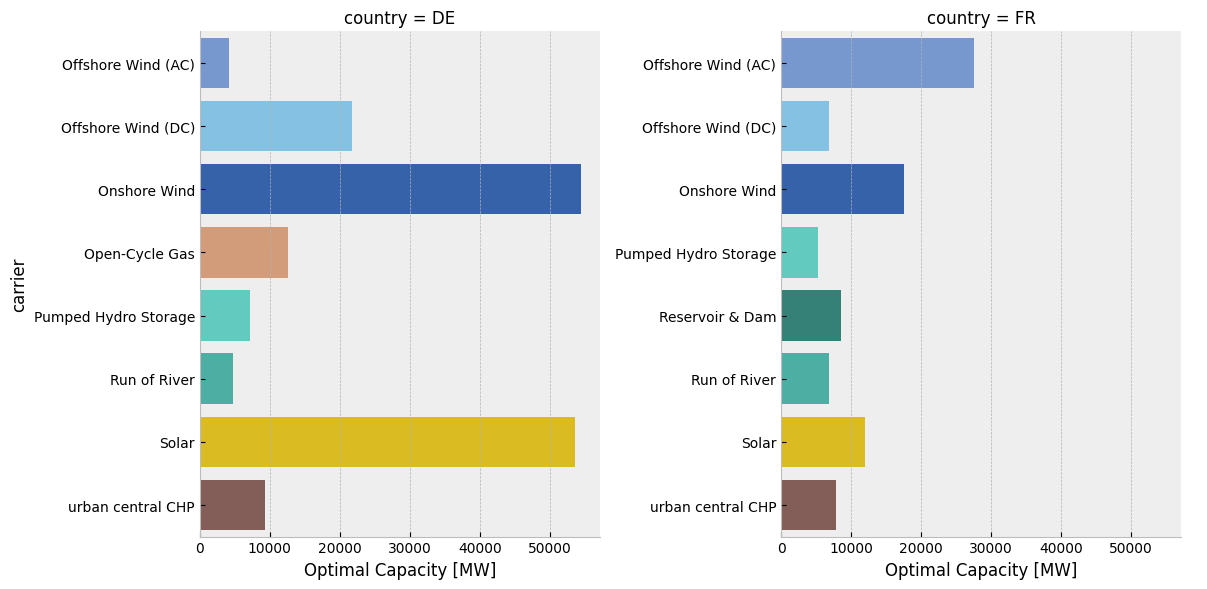

In [62]:
s.optimal_capacity.plot.bar(
    bus_carrier="AC",
    query="value>1e3 and country in ['DE', 'FR']",
    height=6,
    facet_col="country",
);

You can have a closer look to the wind production

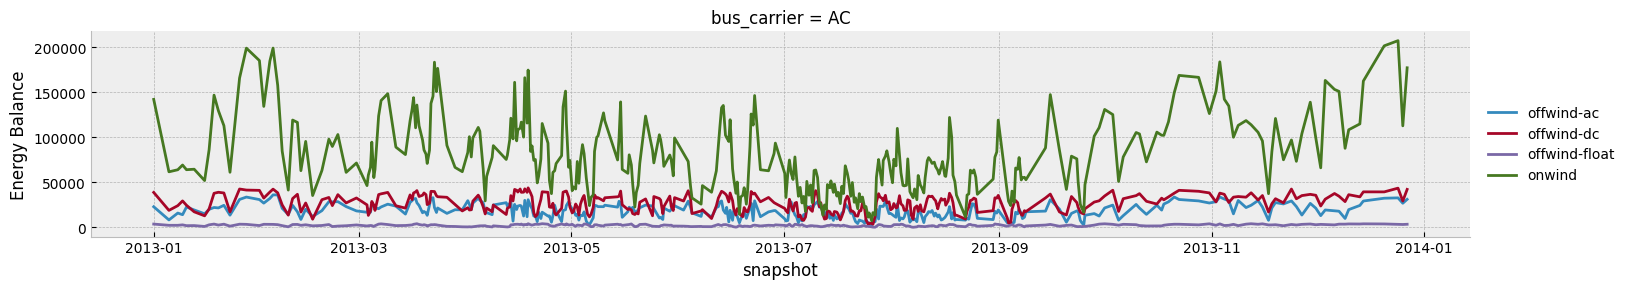

In [63]:
s.energy_balance.plot.line(
    facet_row="bus_carrier",
    y="value",
    x="snapshot",
    carrier="wind",
    nice_names=False,
    color="carrier",
    aspect=5.0,
);

... or to the dispatch for specific countries.

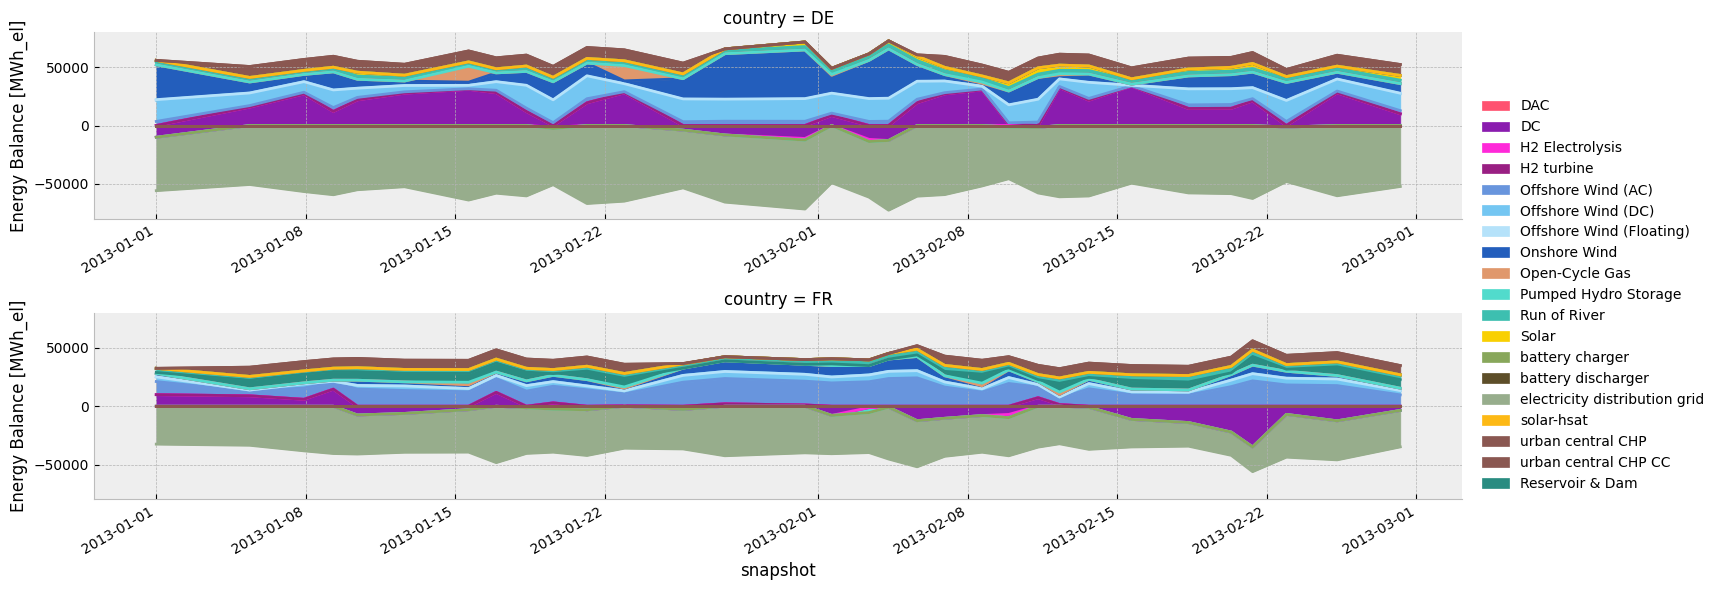

In [64]:
s.energy_balance.plot.area(
    bus_carrier=["AC"],
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="country",
    query="country in ['DE', 'FR'] and snapshot < '2013-03'",
    aspect=5,
);

You can also explore H2 results.

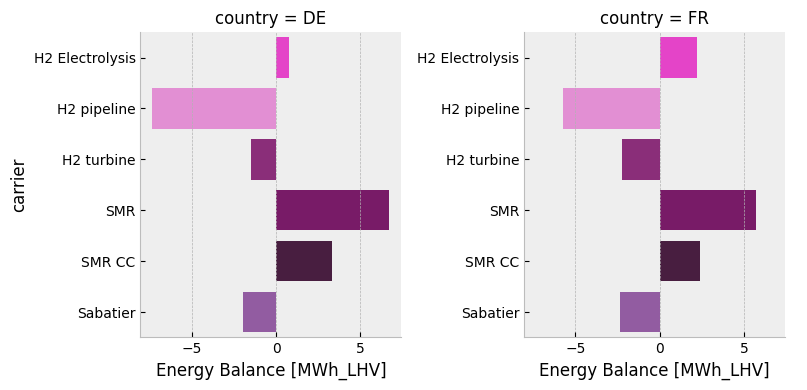

In [65]:
s.energy_balance.plot.bar(
    bus_carrier=["H2"],
    y="carrier",
    x="value",
    color="carrier",
    facet_col="country",
    height=4,
    aspect=1,
    query="country in ['DE', 'FR']",
);

You can also explore the correlation between renewable production and hydrogen.

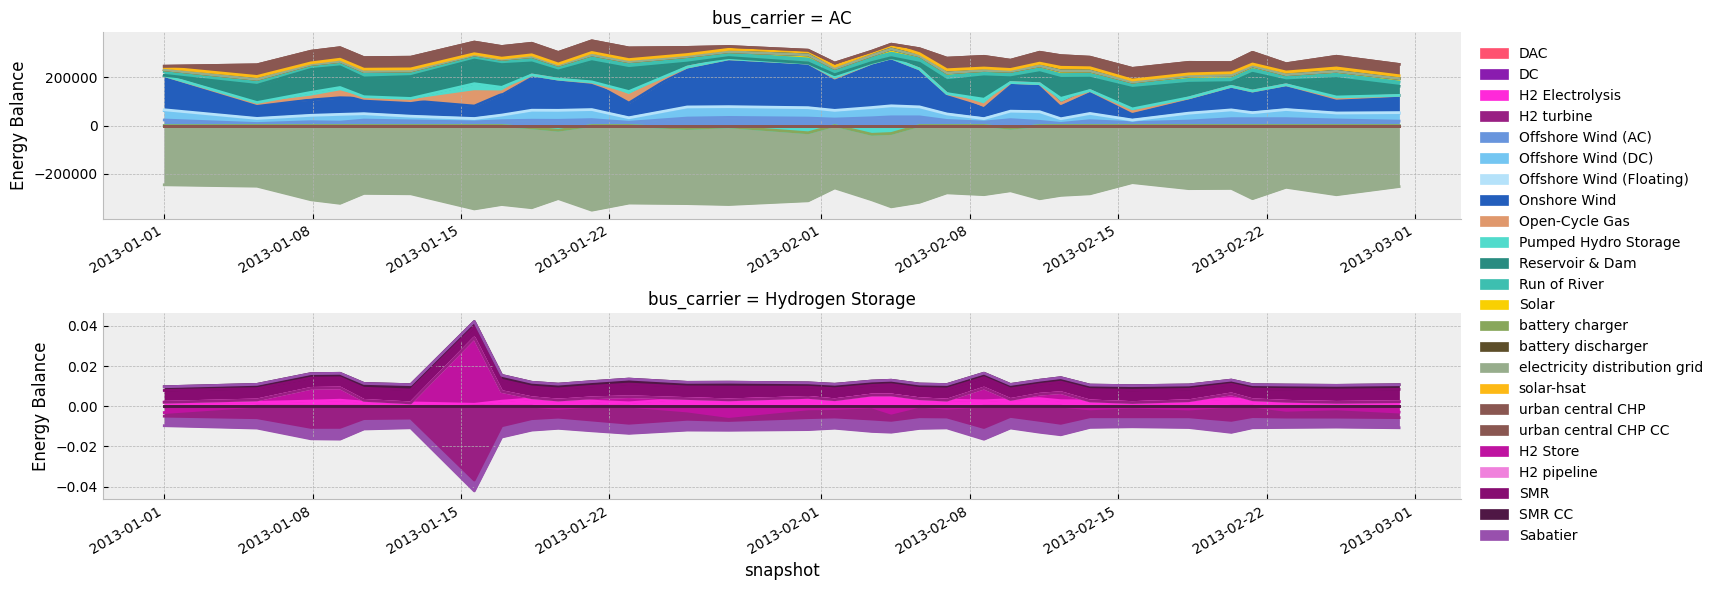

In [66]:
s.energy_balance.plot.area(
    bus_carrier=["AC", "H2"],
    y="value",
    x="snapshot",
    color="carrier",
    stacked=True,
    facet_row="bus_carrier",
    sharex=False,
    sharey=False,
    query="snapshot < '2013-03'",
    aspect=5,
);

There is also the possibility to explore maps.

/Users/daniel/mambaforge/envs/open-tyndp-workshops/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1738: UserWarning:

When combining n.plot() with other plots on a geographical axis, ensure n.plot() is called first or the final axis extent is set initially (ax.set_extent(boundaries, crs=crs)) for consistent legend semicircle sizes.



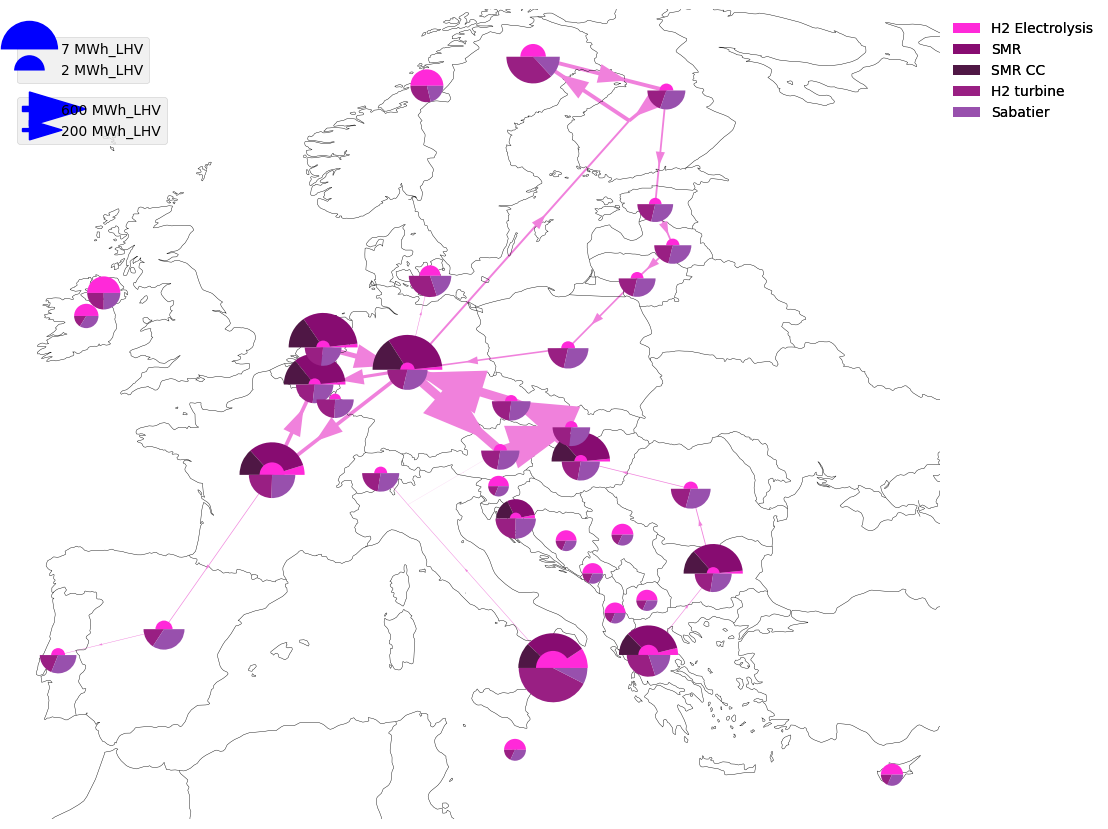

In [67]:
subplot_kw = {"projection": proj}
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=subplot_kw)
s.energy_balance.plot.map(
    bus_carrier="H2",
    ax=ax,
);

But, to get something neat, you might need to code it yourself. Indeed, with some tweaking and construction, we can use PyPSA's plotting to create some really cool visualizations of the resulting net hydrogen flows in the network.

In [68]:
def plot_net_H2_flows(n, regions, countries=[], figsize=(12, 12)):
    network = n.copy()
    if "H2 pipeline" not in n.links.carrier.unique():
        return
    if len(countries) == 0:
        countries = regions.index.values

    linewidth_factor = 5e2
    # MW below which not drawn
    line_lower_threshold = 1e2
    min_energy = 0
    lim = 50
    link_color = "#499a9c"
    flow_factor = 100

    # get H2 energy balance per node
    carrier = "H2"
    h2_energy_balance = network.statistics.energy_balance(
        bus_carrier="H2", comps="Link", groupby=["country", "carrier"]
    ).to_frame()

    to_drop = ["H2 pipeline"]
    # drop pipelines and storages from energy balance
    h2_energy_balance.drop(h2_energy_balance.loc[:, to_drop, :].index, inplace=True)
    # filter for countries
    h2_energy_balance = h2_energy_balance.loc[countries, :, :]
    regions = regions.loc[countries]

    regions["H2"] = (
        h2_energy_balance.groupby(level=0).sum()
        # .div(1e6)  # TWh
        .mul(-1)  # so demand is positive and supply is negative
    )

    # Drop non-hydrogen buses so they don't clutter the plot
    # And filter for countries
    network.buses.drop(network.buses.query("carrier != 'H2'").index, inplace=True)
    network.buses.drop(
        network.buses.query("country not in @countries").index, inplace=True
    )

    # drop all links which are not H2 pipelines
    network.links.drop(
        network.links.index[~network.links.carrier.str.contains("H2 pipeline")],
        inplace=True,
    )

    network.links["flow"] = network.snapshot_weightings.generators @ network.links_t.p0

    positive_order = network.links.bus0 < network.links.bus1
    swap_buses = {"bus0": "bus1", "bus1": "bus0"}
    network.links.loc[~positive_order] = network.links.rename(columns=swap_buses)
    network.links.loc[~positive_order, "flow"] = -network.links.loc[
        ~positive_order, "flow"
    ]
    network.links.index = network.links.apply(
        lambda x: f"H2 pipeline {x.bus0} -> {x.bus1}", axis=1
    )
    network.links = network.links.groupby(network.links.index).agg(
        dict(flow="sum", bus0="first", bus1="first", carrier="first", p_nom_opt="sum")
    )
    network.links.flow = network.links.flow.where(network.links.flow.abs() > min_energy)

    # drop links not connecting countries in country list
    network.links.drop(
        network.links.loc[
            (
                (~network.links.bus0.str.contains("|".join(countries)))
                | (~network.links.bus1.str.contains("|".join(countries)))
            )
        ].index,
        inplace=True,
    )

    proj = ccrs.EqualEarth()
    coords = regions.get_coordinates()
    map_opts["boundaries"] = [
        x for y in zip(coords.min().values, coords.max().values) for x in y
    ]
    regions = regions.to_crs(proj.proj4_init)

    fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})

    link_widths_flows = network.links.flow.div(linewidth_factor).fillna(0)
    # cap link width
    link_widths_flows = link_widths_flows.where(
        (link_widths_flows.abs() < 1) | (link_widths_flows < 0), 1
    ).where(  # 1 where not between 0 and 1 or negative
        (link_widths_flows.abs() < 1) | (link_widths_flows > 0), -1
    )  # -1 where not between 0 and -1 or positive

    network.plot.map(
        geomap=True,
        bus_sizes=0,
        link_colors=link_color,
        link_widths=link_widths_flows,
        branch_components=["Link"],
        ax=ax,
        flow=pd.concat({"Link": link_widths_flows * flow_factor}),
        **map_opts,
    )

    regions.plot(
        ax=ax,
        column="H2",
        cmap="BrBG",
        linewidths=0,
        legend=True,
        vmax=lim,
        vmin=-lim,
        legend_kwds={
            "label": "Hydrogen balance [MWh] \n + Supply, - Demand",
            "shrink": 0.7,
            "extend": "max",
        },
    )

    legend_kw = dict(
        loc="upper left",
        bbox_to_anchor=(-0.1, 1.13),
        frameon=False,
        labelspacing=0.8,
        handletextpad=1,
    )

    sizes = [2, 1, 0.5]
    sizes_str = {2: " over", 1: "", 0.5: ""}
    labels = [f"Net H2 flows{sizes_str[s]} {s} GWh" for s in sizes]
    scale = 1e3 / linewidth_factor
    sizes = [s * scale for s in sizes]
    add_legend_lines(
        ax,
        sizes,
        labels,
        patch_kw=dict(color=link_color),
        legend_kw=legend_kw,
    )

    ax.set_facecolor("white")


map_opts = {
    "boundaries": [-11, 30, 34, 71],
    "geomap_colors": {
        "ocean": "white",
        "land": "white",
    },
}

/Users/daniel/mambaforge/envs/open-tyndp-workshops/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1370: DeprecationWarning:

The `flow` argument is deprecated, use `line_flow`, `link_flow` and `transformer_flow` instead. Multiindex Series are not supported anymore.



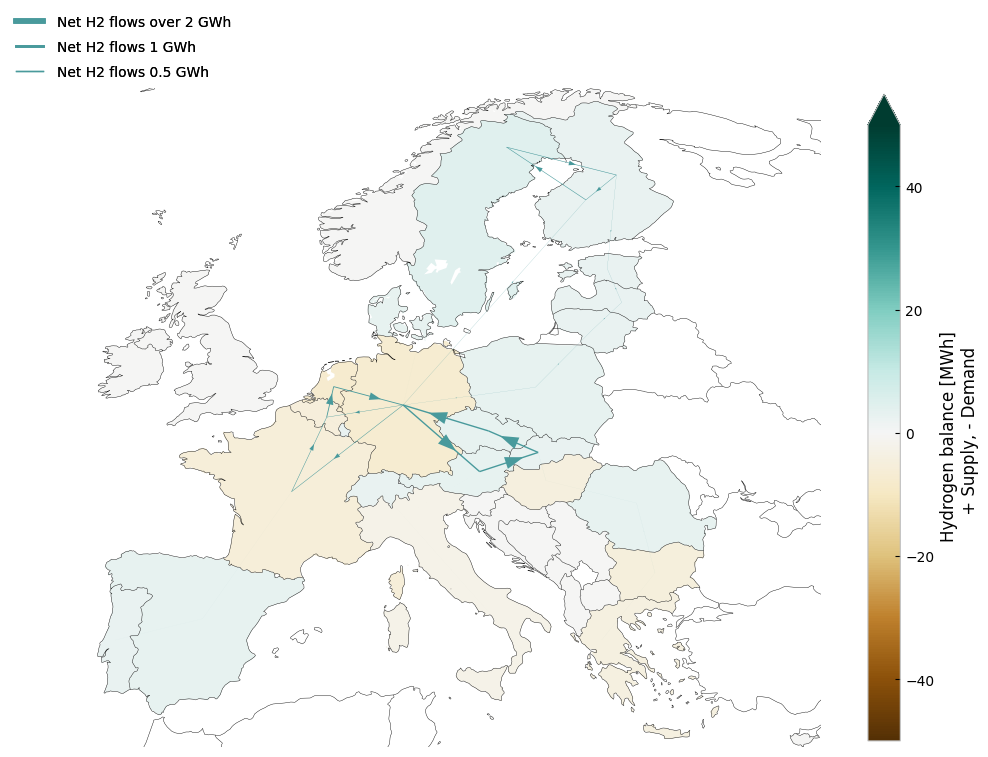

In [69]:
h2_regions = bz.dissolve(by="country")
plot_net_H2_flows(n, h2_regions)

Or, if you want to zoom on specific countries.

/Users/daniel/mambaforge/envs/open-tyndp-workshops/lib/python3.12/site-packages/pypsa/plot/maps/static.py:1370: DeprecationWarning:

The `flow` argument is deprecated, use `line_flow`, `link_flow` and `transformer_flow` instead. Multiindex Series are not supported anymore.



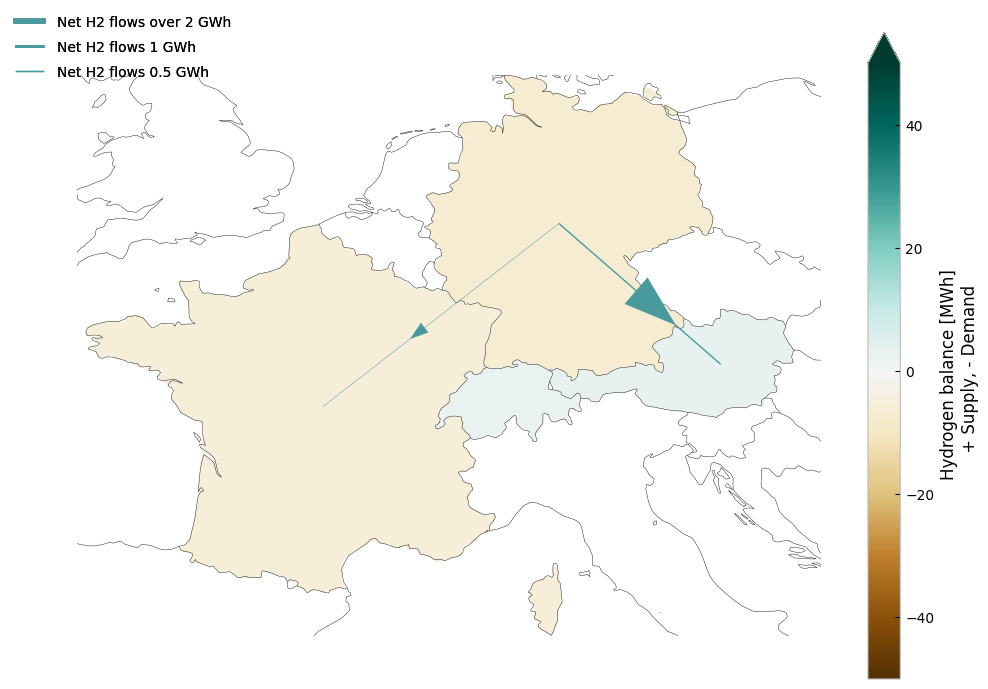

In [70]:
plot_net_H2_flows(n, h2_regions, countries=["DE", "FR", "CH", "AT"])